In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random

#import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as rf
import models.fcnn as fcnn

import data_utils.data_analysis as data_analysis

# create TOY model

In [2]:
t_200=np.linspace(-100,100,201)

In [3]:
def pulse(t,a1,a2,s):
    return (np.exp(-((t-a1)**2)/(2*s*s))
            +np.exp(-((t-a2)**2)/(2*s*s)))

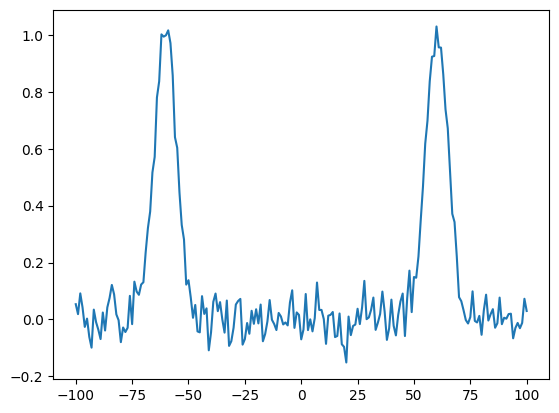

In [4]:
p1=pulse(t_200,-60,60,5)
noise = np.random.normal(0,0.05,len(p1))
p2=p1+noise
plt.plot(t_200,p2)

In [5]:
num_repeat=120
p_list=[]
param_list=[]
i=0
a1_range=np.linspace(-60.0,0,22)
#a1_range=np.repeat(a1_range,num_repeat)
a2_range=np.linspace(0,61,22)
#a2_range=np.repeat(a2_range,num_repeat)
s_range=np.linspace(5,19,5)
#s_range=np.repeat(s_range,num_repeat)
for a1 in a1_range:
    for a2 in a2_range:
        for s in s_range:
            for r in range(num_repeat):
                i+=1
                noise = np.random.normal(0,0.05,len(t_200))
                p_list.append(pulse(t_200,a1,a2,s)+noise)
                param_list.append([a1,a2,s])
print('Num of data points',i)

Num of data points 290400


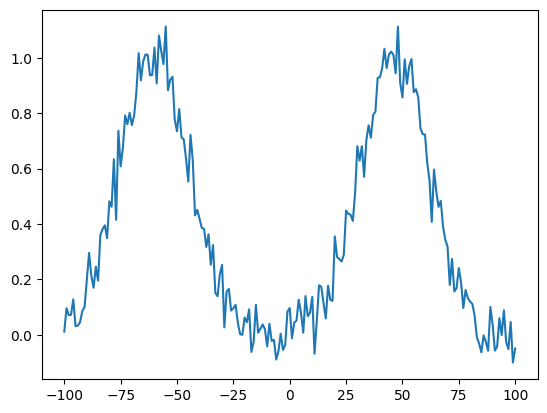

In [6]:
plt.plot(t_200,p_list[10000])

In [7]:
#a1 is order2
#a2 is order3
#a3 is order4
df_input=pd.DataFrame(param_list,columns=['order2','order3','order4'])
df_time_200=pd.Series(t_200)
df_pulse_200=pd.DataFrame(p_list)

# Build the model

In [8]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


In [9]:
#split the dataset (X:dazzler param, Y:wizzler)
#all shots 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_50,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)

In [10]:
### Train a forward model (RF) to compare

In [11]:
def train_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=10
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf#,df_error_forward_rf

In [12]:
%%time
forward_model_rf=train_forward(X_train, X_test, y_train, y_test)

CPU times: user 6min 3s, sys: 4.45 s, total: 6min 7s
Wall time: 6min 7s


### Train the CVAE

In [13]:
#Y: Laser pulse
#X: Dazzler param
def train_nn(y_train_tensor,y_test_tensor,X_train_tensor,X_test_tensor,
			model,device,n_epochs,batch_size,print_freq,learning_rate):
	
    startTime = time.time()
    #Create the model and define the loss and optimizer
    nn_model=model.to(device)

    print('Training on:',device)

    #loss_func=nn_model.loss_func()
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

    #main training loop
    train_error=[]
    train_error_rec=[]
    train_error_kl=[]
    test_error=[]
    test_error_rec=[]
    test_error_kl=[]
    epoch_list=[]
    for epoch in range(n_epochs):
        # set the model in training mode
        nn_model.train()
        
        train_loss=0
        train_loss_rec=0
        train_loss_kl=0
        for i in range(0,len(y_train_tensor),batch_size):
            y_batch=y_train_tensor[i:i+batch_size]
            X_batch=X_train_tensor[i:i+batch_size]
            y_batch =y_batch.to(device)
            X_batch =X_batch.to(device)
            result=nn_model(X_batch,y_batch) #results is a list of [prediction,input,mu,log_var] to be used on the loss function
            loss=nn_model.loss_function(*result,batch_size/len(y_train_tensor))
            optimizer.zero_grad()
            loss['loss'].backward()
            optimizer.step()
            train_loss += loss['loss']
            train_loss_rec += loss['Reconstruction_Loss']
            train_loss_kl += -loss['KLD']

        #get training error
        train_loss=train_loss/(len(y_train_tensor)/batch_size)
        train_loss_rec=train_loss_rec/(len(y_train_tensor)/batch_size)
        train_loss_kl=train_loss_kl/(len(y_train_tensor)/batch_size)
        train_error.append(train_loss.detach().cpu().numpy())
        train_error_rec.append(train_loss_rec.detach().cpu().numpy())
        train_error_kl.append(train_loss_kl.detach().cpu().numpy()*batch_size/len(y_train_tensor))
        #evaluate test error
        with torch.no_grad():
            nn_model.eval()
            y_test_tensor = y_test_tensor.to(device)
            X_test_tensor = X_test_tensor.to(device)
            result=nn_model(X_test_tensor,y_test_tensor)
            test_loss=nn_model.loss_function(*result,batch_size/len(y_train_tensor))
            test_error.append(test_loss['loss'].detach().cpu().numpy())
            test_error_rec.append(test_loss['Reconstruction_Loss'].detach().cpu().numpy())
            test_error_kl.append(-test_loss['KLD'].detach().cpu().numpy()*batch_size/len(y_train_tensor))

        epoch_list.append(epoch+1)
    
        if(epoch%print_freq==0 or epoch+1==n_epochs):
            print(f'Finished epoch {epoch},latest loss {train_loss}')
    #print(train_error)
    #print(test_error)
    endTime = time.time()
    print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
	
    return nn_model,[train_error,train_error_rec,train_error_kl],[test_error,test_error_rec,test_error_kl]

In [14]:
#norm the X (Dazz parameters)
X_train_norm=models_fcnn.norm_data(X_train,X_train)
X_test_norm=models_fcnn.norm_data(X_test,X_train)

In [15]:
#convert data to tensors (no need to normalize values for Y)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)

X_train_tensor=torch.tensor(X_train_norm.values,dtype=torch.float32)
X_test_tensor=torch.tensor(X_test_norm.values,dtype=torch.float32)

In [74]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
model=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=5,
    hidden_dims_enc=[int(total_in),int(total_in*0.7),int(total_in*0.3),int(total_in*0.1)],
    hidden_dims_dec=[int(total_in*1.2),int(total_in*0.7),int(total_in*0.2),int(total_in*0.1),out_dim]
    #hidden_dims_enc=[int(total_in),int(total_in*0.7),int(total_in*0.5),int(total_in*0.3),int(total_in*0.1)],
    #hidden_dims_dec=[int(total_in*1.2),int(total_in*0.7),int(total_in*0.5),int(total_in*0.2),int(total_in*0.1),out_dim]
)

In [75]:
batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
#summary(model,[(batch_size,y_length),(batch_size,x_length)])
summary(model,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 20]                  --
│    └─Sequential: 2-1                   [10, 204]                 --
│    │    └─Linear: 3-1                  [10, 204]                 41,820
│    │    └─LeakyReLU: 3-2               [10, 204]                 --
│    └─Sequential: 2-2                   [10, 142]                 --
│    │    └─Linear: 3-3                  [10, 142]                 29,110
│    │    └─LeakyReLU: 3-4               [10, 142]                 --
│    └─Sequential: 2-3                   [10, 61]                  --
│    │    └─Linear: 3-5                  [10, 61]                  8,723
│    │    └─LeakyReLU: 3-6               [10, 61]                  --
│    └─Sequential: 2-4                   [10, 20]                  --
│    │    └─Linear: 3-7                  [10, 20]                  1,240
│

In [76]:
model_cvae,train_error,test_error=train_nn(y_train_tensor,y_test_tensor,X_train_tensor,X_test_tensor,
			model,device,n_epochs=50,batch_size=1024,print_freq=10,
                                           learning_rate=0.0005)

Training on: cuda
Finished epoch 0,latest loss 0.2573756277561188
Finished epoch 10,latest loss 0.0020153021905571222
Finished epoch 20,latest loss 0.0012606538366526365
Finished epoch 30,latest loss 0.0010560586815699935
Finished epoch 40,latest loss 0.0009341606055386364
Finished epoch 49,latest loss 0.0008088098256848752
Total time taken to train the model: 26.67s


Text(0.5, 0, 'Epoch')

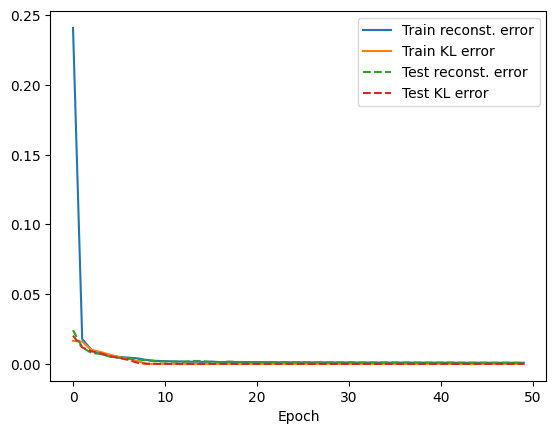

In [77]:
plt.plot(train_error[1],label='Train reconst. error')
plt.plot(train_error[2],label='Train KL error')
plt.plot(test_error[1],linestyle='--',label='Test reconst. error')
plt.plot(test_error[2],linestyle='--',label='Test KL error')
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

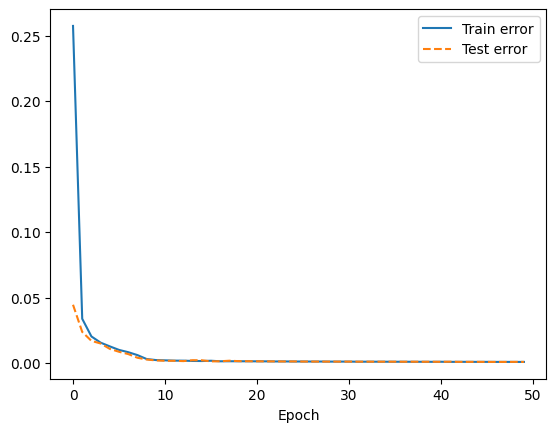

In [78]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

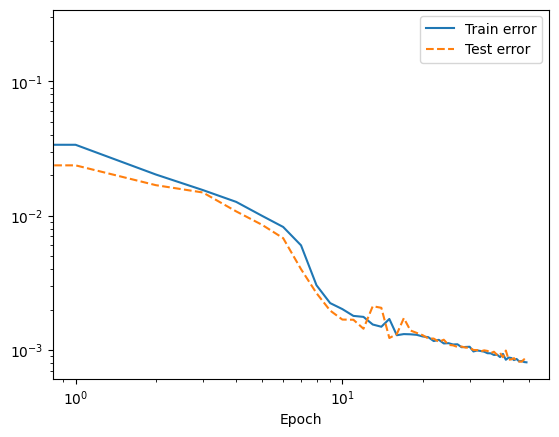

In [79]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

In [80]:
#Take a test pulse and Dazz, get the Dazz from CVAE
index_shot=3032
y_ex=y_test.iloc[index_shot]
X_ex=X_test.iloc[index_shot]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
#X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
#X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)


#Build the distributions functions P(D|p*)
num_samples=10000
dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_fcnn.renorm_data(dazz_norm,X_train)

dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

Known Dazzler values order2     0.000000
order3    31.952381
order4     5.000000
Name: 283811, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


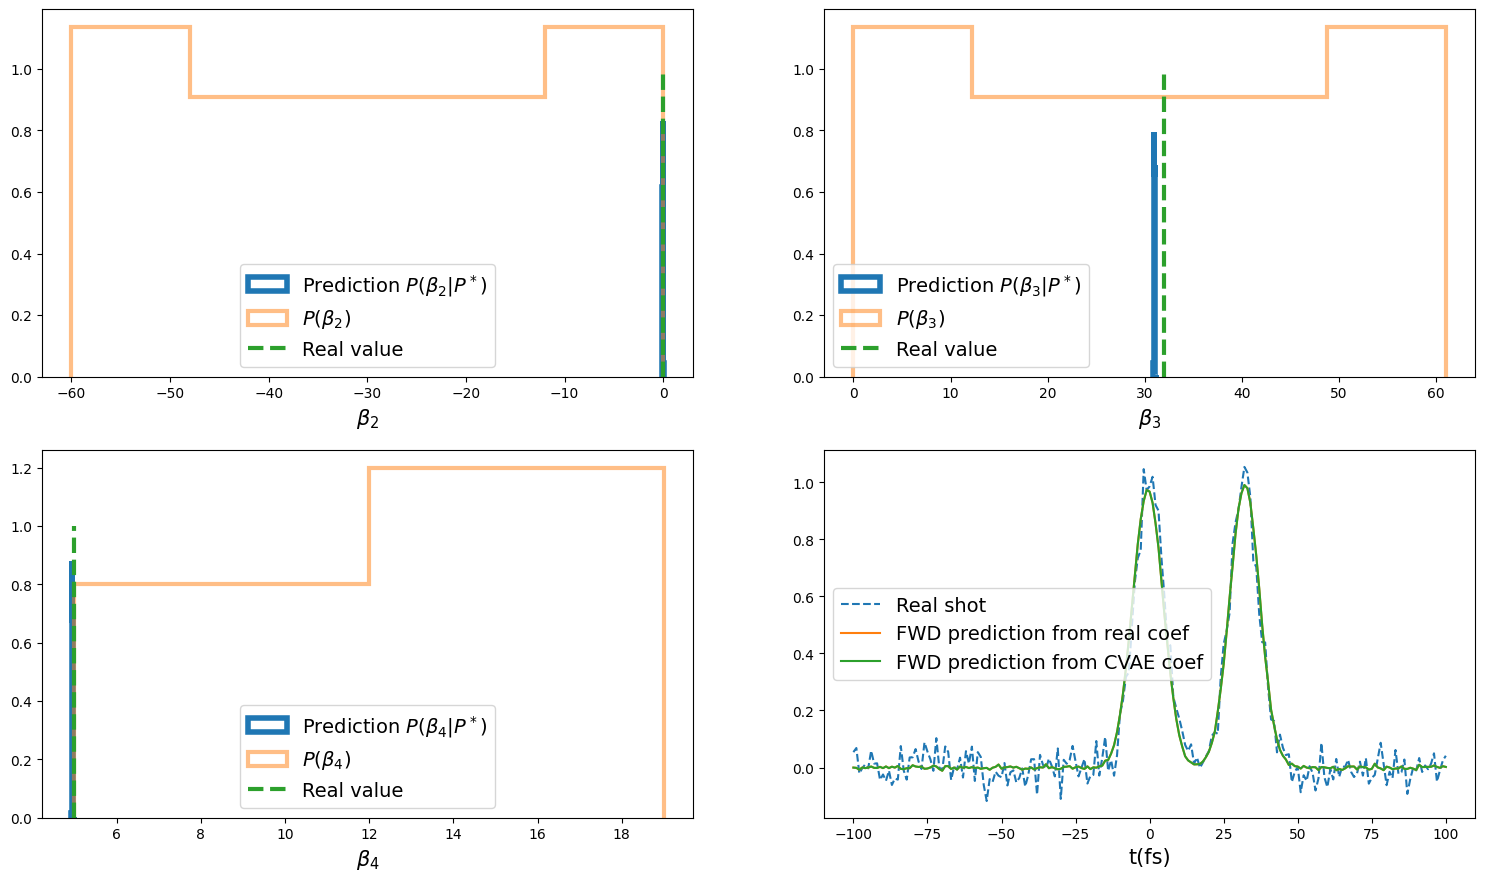

In [81]:
num_bins=100

y_order2=np.linspace(0,1,10)
x_order2=np.full_like(y_order2,X_ex['order2'])

y_order3=np.linspace(0,1,10)
x_order3=np.full_like(y_order3,X_ex['order3'])

y_order4=np.linspace(0,1,10)
x_order4=np.full_like(y_order4,X_ex['order4'])

weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
weights_input2 = 5*np.ones_like(df_input['order2']) / len(df_input['order2'])

weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
weights_input3 = 5*np.ones_like(df_input['order3']) / len(df_input['order3'])

weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
weights_input4 = 2*np.ones_like(df_input['order4']) / len(df_input['order4'])

plt.subplot(2, 2, 1)
plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$',linewidth=4)
plt.hist(df_input['order2'],bins=5,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3)
plt.plot(x_order2,y_order2,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_2$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 2)
plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$',linewidth=4)
plt.hist(df_input['order3'],bins=5,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.5,linewidth=3)
plt.plot(x_order3,y_order3,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_3$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 3)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$',linewidth=4)
plt.hist(df_input['order4'],bins=2,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3)
plt.plot(x_order4,y_order4,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_4$',size=15)
plt.legend(fontsize=14)

#prediction from the FWD with real parameters
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([X_ex]))[0]

#predictions from teh generative model
max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

#print(o2_pred,o3_pred,o4_pred)
y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

plt.subplot(2, 2, 4)
plt.plot(t_200,y_ex,label='Real shot',linestyle='--')
plt.plot(t_200,y_pred_fwd_real,label='FWD prediction from real coef')
plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
plt.xlabel('t(fs)',size=15)
plt.legend(fontsize=14)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### Calculate error in the prediction

In [24]:
# The function gets the Y from a given shot. Predicts its X values. Then uses those X to reconstruct a pulse Y
#        using the forward model. Finally calculates the error from the predictiona dn real Y
#NOTE: X_train is the data that was used to normalized the X values
def get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device):
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex.values)))

    #Build the distributions functions P(D|p*)
    num_samples=10000
    #dazz_out_list=[]
    #for i in range(num_samples):
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_fcnn.renorm_data(dazz_norm,X_train)
        #dazz_out_list.append(dazz_out[0])
    #dazz_out_list=np.vstack(dazz_out_list)
    #P(D|p*) for each coefficient
    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #get the highest prob value from those distr
    num_bins=100
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #Pass those predicted beta values to the forward model
    y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)],columns=['order2', 'order3', 'order4']))[0]
    #calculate the error (Mean Absolute Error)
    error=abs(y_ex-y_pred_fwd_cvae)
    error=error.sum()/len(error)
    return error

In [82]:
%%time
#num_test_shots=500
cvae_error=[]
#for i in range(len(y_test)):
for i in range(5000):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device)
    cvae_error.append(error_pred_cvae)
cvae_error=np.array(cvae_error)

CPU times: user 12min 55s, sys: 617 ms, total: 12min 56s
Wall time: 58.4 s


### Train other models to compare

In [26]:
#round model NN
roundmodelNN=fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodelNN.train(6,#epochs FWD
                 20,#batch size FWD
                 1, #print freq FWD
                 0.001, #learning rate FWF
                   6,#epochs  BWD
                 20,#batch size BWD
                 1, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodelNN.predict(y_test)
error_round_model_nn=roundmodelNN.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.00509228790178895
Finished epoch 1,latest loss 0.0029037895146757364
Finished epoch 2,latest loss 0.0027949493378400803
Finished epoch 3,latest loss 0.0027438453398644924
Finished epoch 4,latest loss 0.0027136863209307194
Finished epoch 5,latest loss 0.002692366251721978
Total time taken to train the model: 74.42s
Training the backward model
Finished epoch 0,latest loss 0.008904158137738705
Finished epoch 1,latest loss 0.0015369986649602652
Finished epoch 2,latest loss 0.0011397955240681767
Finished epoch 3,latest loss 0.0009227903210557997
Finished epoch 4,latest loss 0.0007820171886123717
Finished epoch 5,latest loss 0.0006814970984123647
Total time taken to train the model: 71.99s
Calculating the Mean Absolute Error


### Random guess model (using FWD RF)

In [27]:
## Random guess 'model'
o2min=X_test['order2'].min()
o2max=X_test['order2'].max()
o3min=X_test['order3'].min()
o3max=X_test['order3'].max()
o4min=X_test['order4'].min()
o4max=X_test['order4'].max()

o2_list=[]
o3_list=[]
o4_list=[]
for i in range(len(X_test)):
    o2_list.append(random.uniform(o2min,o2max))
    o3_list.append(random.uniform(o3min,o3max))
    o4_list.append(random.uniform(o4min,o4max))

X_test_rand=pd.DataFrame({'order2':o2_list,'order3':o3_list,'order4':o4_list})#,o3_list,o4_list])#,columns=['order2','order3','order4'])

#Pass those predicted (but random) beta values to the forward model
y_pred_fwd_rand=rf.make_rf_prediction(forward_model_rf,X_test_rand)
#calculate the error (Mean Absolute Error)
error_rand=abs(y_test-y_pred_fwd_rand)
error_rand=error_rand.sum(axis=1)/y_test.shape[1]

### Real beta values + random forest fwd

In [28]:
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,X_test)
#calculate the error (Mean Absolute Error)
error_real_rf=abs(y_test-y_pred_fwd_real)
error_real_rf=error_real_rf.sum(axis=1)/y_test.shape[1]

Text(0.5, 1.0, 'Model Accuracy (round trip)')

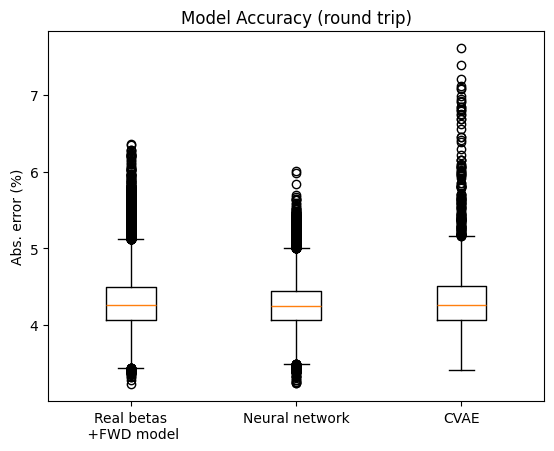

In [83]:
error_dist=[100*error_real_rf,
            100*error_round_model_nn,
            100*cvae_error]
labels=['Real betas\n +FWD model','Neural network','CVAE']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
#plt.ylim(0,10)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (round trip)')

## Data size impact on CVAE

In [30]:
#np.random.seed(10)
def drop_shots(drop_factor,df_input_clean,df_time_clean):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input_clean)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input_clean.index, remove_n, replace=False)
    df_input_subset = df_input_clean.drop(drop_indices)
    df_time_subset = df_time_clean.drop(drop_indices)
    #df_freq_int_subset = df_freq_int_clean.drop(drop_indices)
    #print(df_input_subset)
    #print(df_time_subset)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [45]:
drop_factor=0.48
df_input_subset_150k,df_time_subset_150k=drop_shots(drop_factor,df_input,df_pulse_200)

drop_factor=0.76
df_input_subset_70k,df_time_subset_70k=drop_shots(drop_factor,df_input,df_pulse_200)

drop_factor=0.90
df_input_subset_30k,df_time_subset_30k=drop_shots(drop_factor,df_input,df_pulse_200)

The datasize is no: 151008
The datasize is no: 69696
The datasize is no: 29040


In [32]:
#using the (big dataset) pretrained FWD model
def get_cvae_from_subset(t_200,df_input_subset,df_time_subset,forward_model_rf):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset=models_tools.split_dataset_roundtrip(df_input_subset,df_time_subset,rand_split=False)
    
    #norm the X (Dazz parameters)
    X_train_norm_subset=models_fcnn.norm_data(X_train_subset,X_train_subset)
    X_test_norm_subset=models_fcnn.norm_data(X_test_subset,X_train_subset)

    #convert data to tensors (no need to normalize values for Y)
    y_train_tensor_subset=torch.tensor(y_train_subset.values,dtype=torch.float32)
    y_test_tensor_subset=torch.tensor(y_test_subset.values,dtype=torch.float32)

    X_train_tensor_subset=torch.tensor(X_train_norm_subset.values,dtype=torch.float32)
    X_test_tensor_subset=torch.tensor(X_test_norm_subset.values,dtype=torch.float32)

    #define the model
    total_in=len(t_200)+len(X_train_subset.columns) #number of input: pulse+Dazz
    out_dim=len(X_train_subset.columns)#dazz coefficients
    model_subset=models_vae.ConditionalVAE(
        in_pulse_features=len(t_200),
        num_param=out_dim,
        latent_dim=5,
        hidden_dims_enc=[int(total_in),int(total_in*0.7),int(total_in*0.5),int(total_in*0.3),int(total_in*0.1)],
        hidden_dims_dec=[int(total_in*1.2),int(total_in*0.7),int(total_in*0.5),int(total_in*0.2),int(total_in*0.1),out_dim]
    )

    model_cvae_subset,train_error_subset,test_error_subset=train_nn(y_train_tensor_subset,y_test_tensor_subset,X_train_tensor_subset,X_test_tensor_subset,
    			#model_subset,device,n_epochs=600,batch_size=1024,print_freq=50,learning_rate=0.001)
                model_subset,device,n_epochs=40,batch_size=1024,print_freq=5,
                                                                    learning_rate=0.0005)

    #train a RF forward model
    #print('Training the RF FWD mode')
    #forward_model_rf_subset=train_forward(X_train_subset, X_test_subset, y_train_subset, y_test_subset)

    cvae_error_subset=[]
    num_test_shots=5000
    if (len(y_test_subset)<num_test_shots):
        num_test_shots=len(y_test_subset)
    
    for i in range(num_test_shots):
        #index_shot=random.randint(0,len(y_test))
        y_ex=y_test_subset.iloc[i]
        error_pred_cvae=get_error_cvae(y_ex,model_cvae_subset,forward_model_rf,X_train_subset,device)
        cvae_error_subset.append(error_pred_cvae)
    cvae_error_subset=np.array(cvae_error_subset)
    return cvae_error_subset,model_cvae_subset

In [37]:
cvae_error_150k,model_cvae_150k=get_cvae_from_subset(t_200,df_input_subset_150k,df_time_subset_150k,forward_model_rf)

Training on: cuda
Finished epoch 0,latest loss 0.46377992630004883
Finished epoch 5,latest loss 0.02256757766008377
Finished epoch 10,latest loss 0.0031438868027180433
Finished epoch 15,latest loss 0.0021136063151061535
Finished epoch 20,latest loss 0.00171020592097193
Finished epoch 25,latest loss 0.0015388455940410495
Finished epoch 30,latest loss 0.0013940592762082815
Finished epoch 35,latest loss 0.0012570193503051996
Finished epoch 39,latest loss 0.0011799215571954846
Total time taken to train the model: 10.84s


In [46]:
cvae_error_70k,model_cvae_70k=get_cvae_from_subset(t_200,df_input_subset_70k,df_time_subset_70k,forward_model_rf)

Training on: cuda
Finished epoch 0,latest loss 0.8330200910568237
Finished epoch 5,latest loss 0.03963606432080269
Finished epoch 10,latest loss 0.00899474322795868
Finished epoch 15,latest loss 0.005156568251550198
Finished epoch 20,latest loss 0.0038912135642021894
Finished epoch 25,latest loss 0.0033736415207386017
Finished epoch 30,latest loss 0.0024921172298491
Finished epoch 35,latest loss 0.0021159325260668993
Finished epoch 39,latest loss 0.02390962839126587
Total time taken to train the model: 5.78s


In [38]:
cvae_error_30k,model_cvae_30k=get_cvae_from_subset(t_200,df_input_subset_30k,df_time_subset_30k,forward_model_rf)

Training on: cuda
Finished epoch 0,latest loss 0.9637824892997742
Finished epoch 5,latest loss 0.17692004144191742
Finished epoch 10,latest loss 0.04572287201881409
Finished epoch 15,latest loss 0.01930839754641056
Finished epoch 20,latest loss 0.012218846939504147
Finished epoch 25,latest loss 0.008838823065161705
Finished epoch 30,latest loss 0.006719727069139481
Finished epoch 35,latest loss 0.005353446118533611
Finished epoch 39,latest loss 0.004552303347736597
Total time taken to train the model: 2.26s


Text(0.5, 1.0, 'CVAE error (mae)')

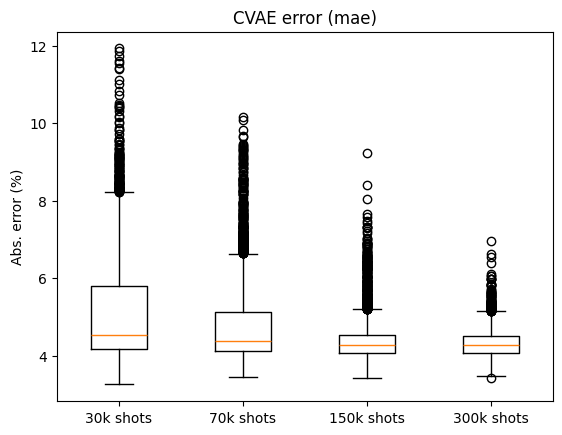

In [47]:
error_dist=[100*cvae_error_30k,
            100*cvae_error_70k,
            100*cvae_error_150k,
            100*cvae_error]
labels=['30k shots','70k shots','150k shots','300k shots']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
#plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('CVAE error (mae)')

### Analyze small dataset model

In [40]:
#Take a test pulse and Dazz, get the Dazz from CVAE
index_shot=3027
y_ex=y_test.iloc[index_shot]
X_ex=X_test.iloc[index_shot]
y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
#X_ex_tensor=torch.tensor(X_ex.values,dtype=torch.float32)
#X_ex_tensor=torch.reshape(X_ex_tensor,(1,3))
print('Known Dazzler values',X_ex)


#Build the distributions functions P(D|p*)
#first fromt the small dataset
num_samples=10000
dazz_norm_30k=model_cvae_30k.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out_30k=models_fcnn.renorm_data(dazz_norm_30k,X_train)

dist_order2_30k=dazz_out_30k[:,0]#dazz_out_list[:,0]
dist_order3_30k=dazz_out_30k[:,1]#dazz_out_list[:,1]
dist_order4_30k=dazz_out_30k[:,2]#dazz_out_list[:,2]

#tehn big dataset
#num_samples=10000
dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
dazz_out=models_fcnn.renorm_data(dazz_norm,X_train)

dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

Known Dazzler values order2   -22.857143
order3    17.428571
order4    12.000000
Name: 175479, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


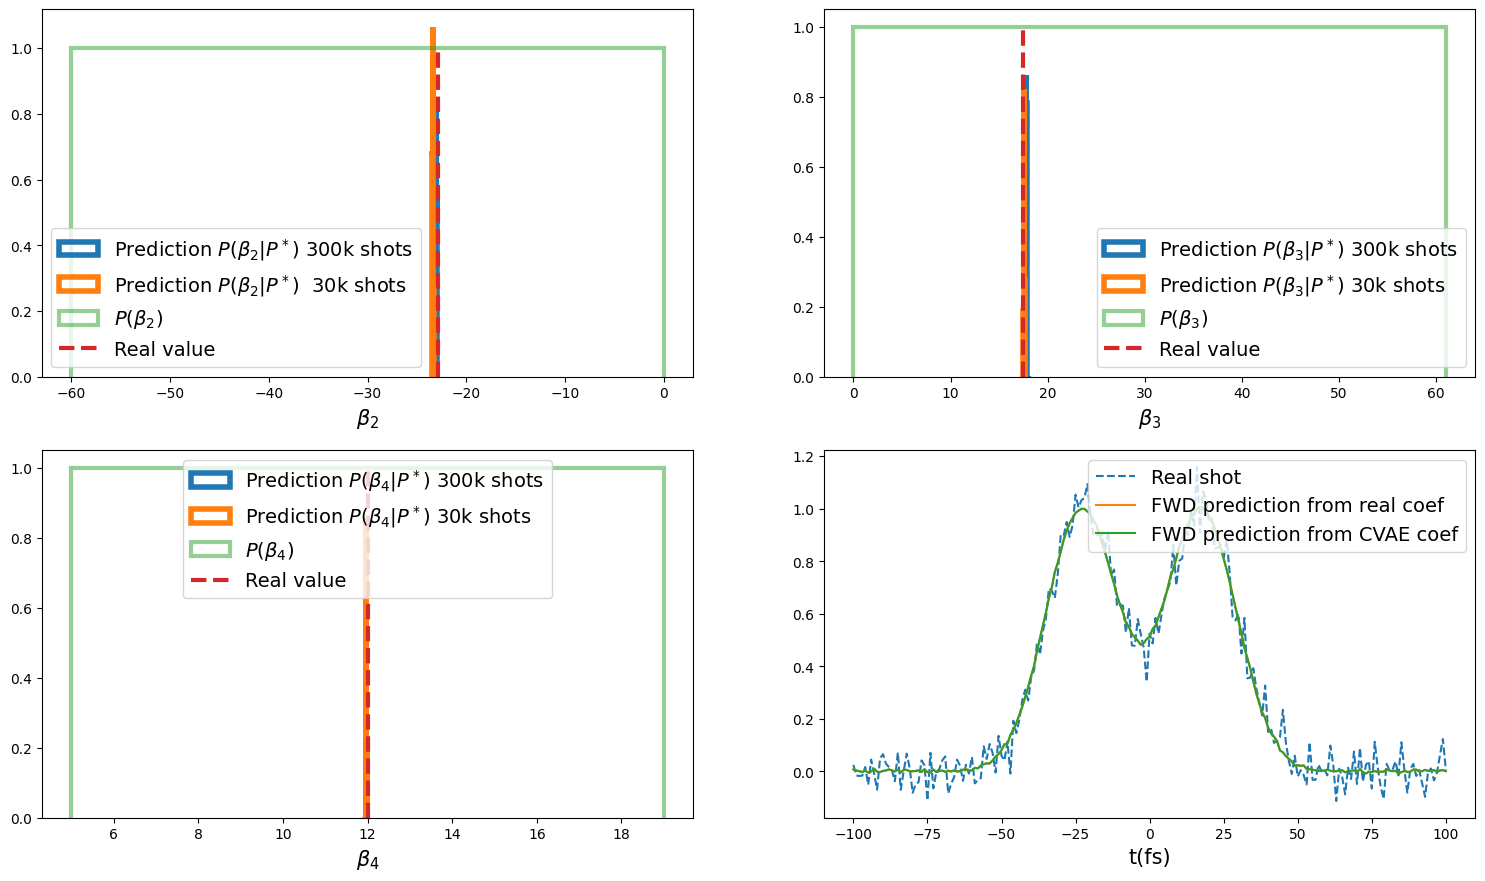

In [41]:
num_bins=100

y_order2=np.linspace(0,1,10)
x_order2=np.full_like(y_order2,X_ex['order2'])

y_order3=np.linspace(0,1,10)
x_order3=np.full_like(y_order3,X_ex['order3'])

y_order4=np.linspace(0,1,10)
x_order4=np.full_like(y_order4,X_ex['order4'])

weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
weights_input2 = 1*np.ones_like(df_input['order2']) / len(df_input['order2'])

weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
weights_input3 = 1*np.ones_like(df_input['order3']) / len(df_input['order3'])

weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
weights_input4 = 1*np.ones_like(df_input['order4']) / len(df_input['order4'])

plt.subplot(2, 2, 1)
plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$ 300k shots',linewidth=4)
plt.hist(dist_order2_30k,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$  30k shots',linewidth=4)
plt.hist(df_input['order2'],bins=1,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3)
plt.plot(x_order2,y_order2,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_2$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 2)
plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$ 300k shots',linewidth=4)
plt.hist(dist_order3_30k,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$ 30k shots',linewidth=4)
plt.hist(df_input['order3'],bins=1,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.5,linewidth=3)
plt.plot(x_order3,y_order3,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_3$',size=15)
plt.legend(fontsize=14)

plt.subplot(2, 2, 3)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$ 300k shots',linewidth=4)
plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$ 30k shots',linewidth=4)
plt.hist(df_input['order4'],bins=1,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3)
plt.plot(x_order4,y_order4,linestyle='--',label='Real value',linewidth=3)
plt.xlabel(r'$\beta_4$',size=15)
plt.legend(fontsize=14)

#prediction from the FWD with real parameters
y_pred_fwd_real=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([X_ex]))[0]

#predictions from teh generative model
max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

#print(o2_pred,o3_pred,o4_pred)
y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

plt.subplot(2, 2, 4)
plt.plot(t_200,y_ex,label='Real shot',linestyle='--')
plt.plot(t_200,y_pred_fwd_real,label='FWD prediction from real coef')
plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
plt.xlabel('t(fs)',size=15)
plt.legend(fontsize=14)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()